# Cirrhosis Hastalığı Tahmini
### Cirrhosis (Siroz) hastalığı nedir ?
*Cirrhosis, karaciğerin ciddi ve kronik hasar gördüğü bir karaciğer hastalığıdır. Karaciğer, vücutta birçok önemli görevi olan bir organ olduğu için, bu tür hasarlar ciddi sağlık sorunlarına neden olabilir. Cirrhosis genellikle uzun vadeli alkol kötüye kullanımı, viral hepatit (örneğin, hepatit B veya C), yağlı karaciğer hastalığı, otoimmün hastalıklar, genetik faktörler veya uzun süreli toksik madde maruziyeti gibi faktörlerin neden olduğu karaciğer hasarı sonucu gelişir.*

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import optuna

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.impute import SimpleImputer
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.pipeline import make_pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_columns",100)

In [37]:
# Load the training data
train_data = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv', index_col='id')

# Load the test data
test_data = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv', index_col='id')

# Load the sample
sample = pd.read_csv("/kaggle/input/playground-series-s3e26/sample_submission.csv")

# Display the first few rows of the training data
train_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [38]:
test_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
id,,,,,,,,,,,,,,,,,,
7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [39]:
print("Train Data Shape:",train_data.shape)
print("Test Data Shape:",test_data.shape)

Train Data Shape: (7905, 19)
Test Data Shape: (5271, 18)


In [40]:
def null_values(a):
    null = a.isnull().sum()
    null_percent = a.isnull().mean()*100

    nulls = pd.concat([null.rename('Null Values'), null_percent.rename("Null Values Percent")],axis=1)
    nulls = nulls.sort_values(by='Null Values Percent',ascending=False)
    print(nulls)
    
print("TRAIN DATA")
print("")
null_values(train_data),
print("")
print("TEST DATA")
null_values(test_data)

TRAIN DATA

               Null Values  Null Values Percent
N_Days                   0                  0.0
Albumin                  0                  0.0
Stage                    0                  0.0
Prothrombin              0                  0.0
Platelets                0                  0.0
Tryglicerides            0                  0.0
SGOT                     0                  0.0
Alk_Phos                 0                  0.0
Copper                   0                  0.0
Cholesterol              0                  0.0
Drug                     0                  0.0
Bilirubin                0                  0.0
Edema                    0                  0.0
Spiders                  0                  0.0
Hepatomegaly             0                  0.0
Ascites                  0                  0.0
Sex                      0                  0.0
Age                      0                  0.0
Status                   0                  0.0

TEST DATA
               Nu

In [41]:
# Identifying categorical and numerical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train_data.select_dtypes(include=['int64','float64']).columns.tolist()

print('Kategorik Stünlar :',categorical_cols)
print()
print('Numerik Stünlar :',numerical_cols)

Kategorik Stünlar : ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']

Numerik Stünlar : ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


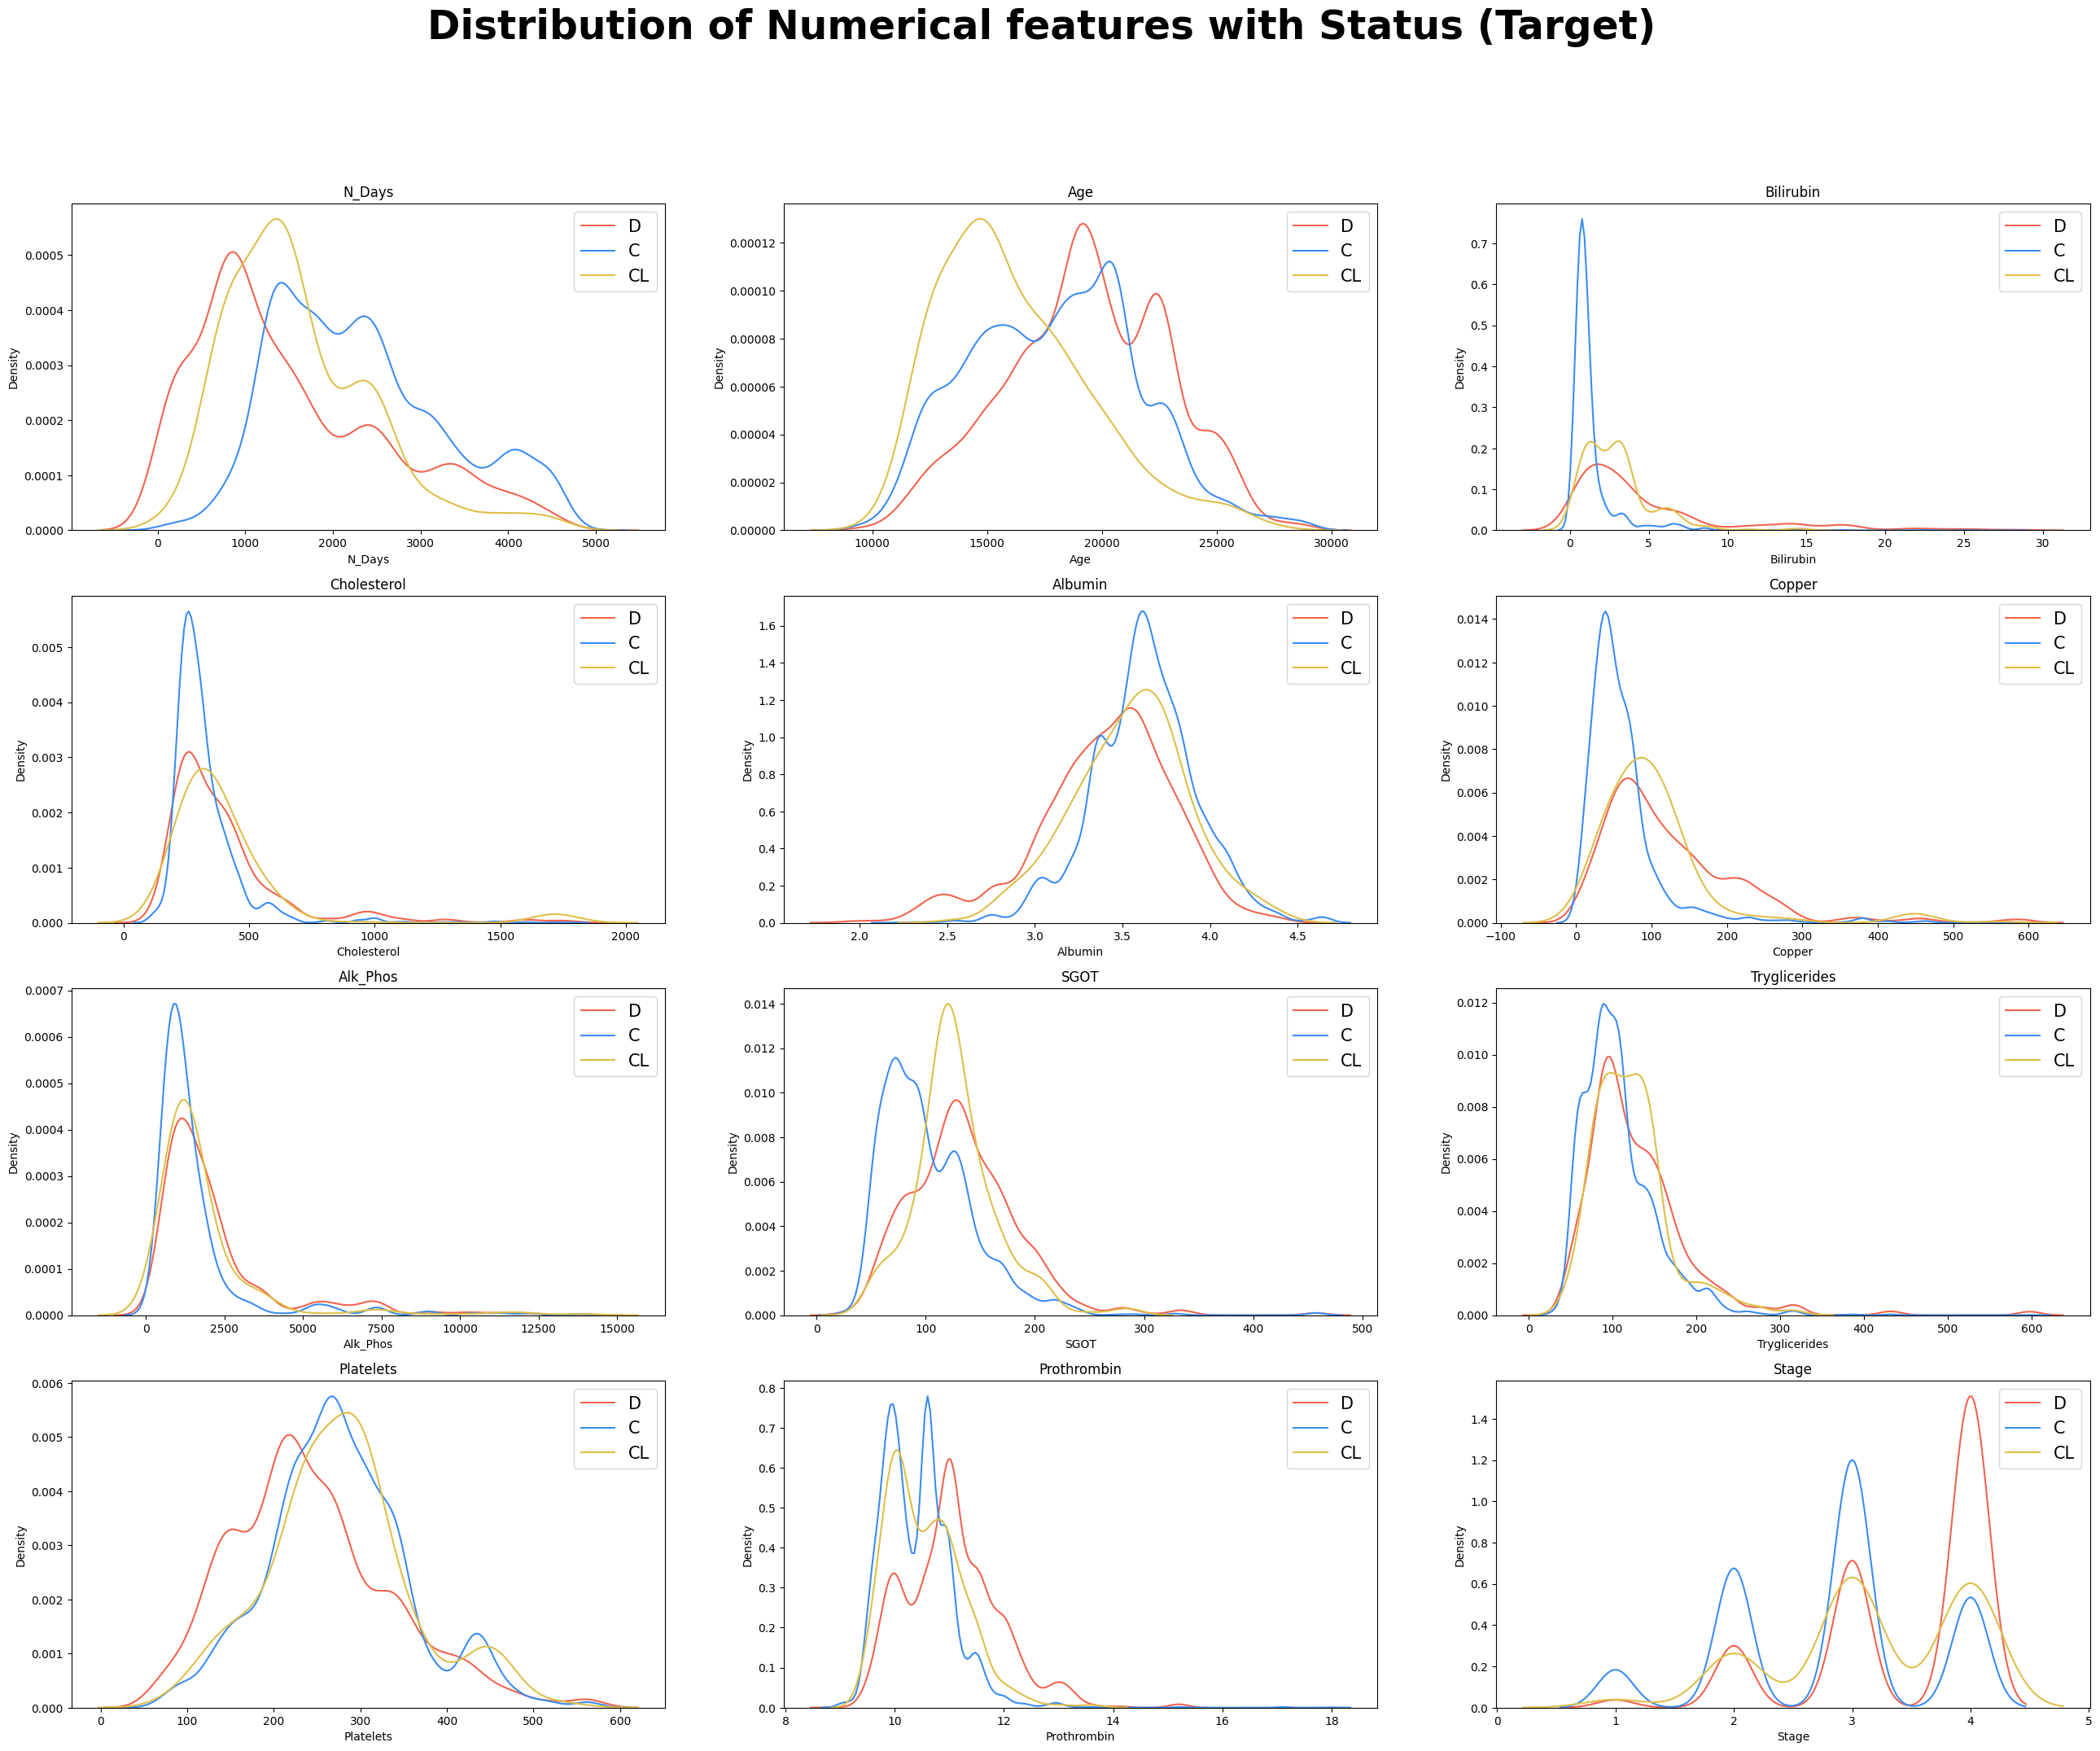

In [42]:
fig = plt.figure(figsize=[32, 24])
fig.suptitle('Distribution of Numerical features with Status (Target) ', fontsize=35, fontweight='bold')
for i, col in enumerate(numerical_cols):
    ax = fig.add_subplot(4, 3, i+1)
    sns.kdeplot(train_data[train_data['Status'] == 'D'][col], color='#f2634e', label='D')
    sns.kdeplot(train_data[train_data['Status'] == 'C'][col], color='#3a8cf2', label='C')
    sns.kdeplot(train_data[train_data['Status'] == 'CL'][col], color='#debe49', label='CL')
    ax.set_title(col)
    ax.legend(fontsize=15)
plt.show()

# Label Encoder

In [43]:
le = LabelEncoder()
train_data[categorical_cols] = train_data[categorical_cols].apply(lambda col: le.fit_transform(col))

In [44]:
train_data

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,0,21532,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2
1,2574,1,19237,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0
2,3428,1,13727,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2
3,2576,1,18460,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0
4,788,1,16658,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,0,16839,0,0,0,0,0,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,0
7901,1492,1,17031,0,0,1,0,0,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,0
7902,1576,0,25873,0,0,0,1,1,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,2


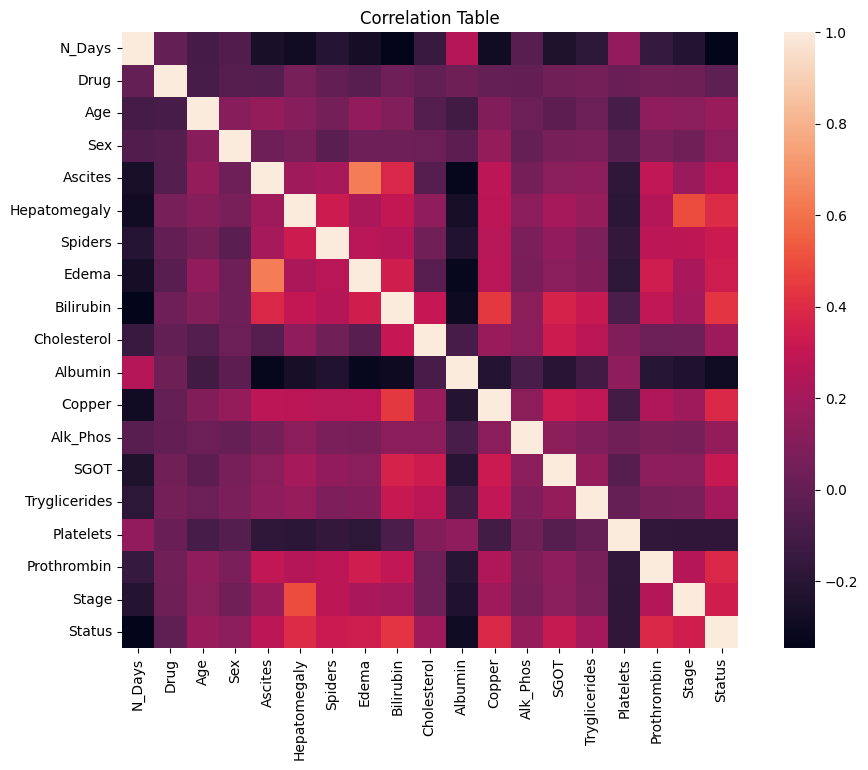

In [45]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(), vmax=1,square=True)
plt.title("Correlation Table")
plt.show()

# Outliers

In [46]:
# IQR hesapla ve aykırı değerleri çıkar
Q1 = train_data[numerical_cols].quantile(0.25)
Q3 = train_data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_data = train_data[~((train_data[numerical_cols] < (Q1 - 1.5 * IQR)) | (train_data[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
 

In [47]:
train_data.shape #7000 den baya düştü model eğitirken faydasını görmez isek iptal ederiz.

(5477, 19)

# New Features

In [48]:
def TransForm(data):
    data["AgeYear"] = data["Age"] // 365 # '//' operatörü, tamsayı bölmesi (floor division) yapar ve bölme işleminin sonucunu en yakın alt tamsayıya yuvarlar
    
    data['Bilirubin_AlkPhos_Ratio'] = data['Bilirubin'] / data['Alk_Phos']
    data['Age_Bilirubin_Interaction'] = data['Age'] * data['Bilirubin']
    
    data['Age_Liver_Disease_Progression'] = data['Age'] * data['Stage']
    data['Copper_Load'] = data['Copper'] / data['Alk_Phos']
    data['Liver_Function'] = data['Bilirubin'] * data['Albumin'] / (data['Alk_Phos'] + data['SGOT'])
    data['Metabolic_Ratio'] = data['Cholesterol'] / data['Tryglicerides']
    
    data['Transplant_Biomarker'] = data['Bilirubin'] * data['Albumin'] / data['Alk_Phos']
    data['N_Days_Age_Ratio'] = data['N_Days'] / data['Age'] / 365
    
    return data

In [49]:
train_data

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,0,21532,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2
1,2574,1,19237,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0
2,3428,1,13727,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2
3,2576,1,18460,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0
4,788,1,16658,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7897,1455,1,16898,0,0,0,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,151.0,9.8,3.0,0
7899,1413,1,24622,0,0,0,0,0,1.3,262.0,3.73,65.0,2045.0,89.90,78.0,181.0,11.0,3.0,2
7901,1492,1,17031,0,0,1,0,0,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,0


In [50]:
TransForm(train_data)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,AgeYear,Bilirubin_AlkPhos_Ratio,Age_Bilirubin_Interaction,Age_Liver_Disease_Progression,Copper_Load,Liver_Function,Metabolic_Ratio,Transplant_Biomarker,N_Days_Age_Ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,999,0,21532,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2,58,0.001437,49523.6,64596.0,0.107433,0.004327,5.015873,0.004813,0.000127
1,2574,1,19237,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,52,0.000625,17313.3,57711.0,0.043750,0.002023,4.136364,0.002213,0.000367
2,3428,1,13727,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2,37,0.003207,45299.1,54908.0,0.127308,0.010202,5.980000,0.011385,0.000684
3,2576,1,18460,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,50,0.000363,11076.0,55380.0,0.035088,0.001218,2.666667,0.001270,0.000382
4,788,1,16658,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,45,0.000931,18323.8,66632.0,0.053345,0.003073,3.604167,0.003400,0.000130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7897,1455,1,16898,0,0,0,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,151.0,9.8,3.0,0,46,0.005067,57453.2,50694.0,0.213115,0.015306,3.875000,0.017887,0.000236
7899,1413,1,24622,0,0,0,0,0,1.3,262.0,3.73,65.0,2045.0,89.90,78.0,181.0,11.0,3.0,2,67,0.000636,32008.6,73866.0,0.031785,0.002271,3.358974,0.002371,0.000157
7901,1492,1,17031,0,0,1,0,0,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,0,46,0.000625,15327.9,68124.0,0.043056,0.001951,3.333333,0.002144,0.000240


# Modelling

In [51]:
# For Validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV ,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm

# For Parametor tuning
import optuna
from optuna.samplers import TPESampler

# For Classifying
from sklearn import svm
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

In [52]:
from sklearn.model_selection import cross_val_score, cross_validate

## Optuna, hiperparametre optimizasyonu için kullanılan bir Python kütüphanesi

In [53]:
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': len(set(y_train)),
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 10),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test)
    loss = log_loss(y_test, y_pred_proba)

    return loss

In [54]:
x= train_data.drop('Status',axis=1)
y= train_data['Status'].astype('int64')

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Best trial:')
trial = study.best_trial

In [56]:
params1 ={'booster': 'gbtree', #kullanılan booster tipi
          'lambda': 5.408956111308184e-05, #L2 düzenlileştirme terimi
          'alpha': 1.4439921127839267e-08, #L1 düzenlileştirme terimi
          'n_estimators': 91,#oluşturulacak ağaç sayısı
          'eta': 0.11134950417574578, #öğrenme oranı
          'gamma': 5.972085046860187e-08, #minimum kayıp azalması için gerekli olan minimum ayrım
          'max_depth': 3, #ağacın maksimum derinliği
          'subsample': 0.9149156056451584, #her ağaç için kullanılacak örneklerin oranı
          'colsample_bytree': 0.4317789984227294, #her ağaç için kullanılacak özelliklerin oranı
          'min_child_weight': 1.3951670450785647, #ağacın daha fazla bölünmesi için gereken minimum örnek ağırlığı
         }

In [57]:
params2 ={'n_estimators': 635,
          'learning_rate': 0.015950500681269315,
          'max_depth': 6,
          'subsample': 0.37366355863137074,
          'colsample_bytree': 0.3717919545414308,
          'min_child_weight': 8}

In [58]:
# Instance model
XGBC = XGBClassifier(**params2, random_state=42)

# Stratified K-Fold Cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [59]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# cross_validate fonksiyonu ile çapraz doğrulama yapın
cv_results = cross_validate(XGBC, x, y, cv=kf, scoring=scoring)

# Sonuçları al
accuracies = cv_results['test_accuracy']
precisions = cv_results['test_precision_macro']
recalls = cv_results['test_recall_macro']
f1s = cv_results['test_f1_macro']

# Metriklerin değerlerini yazdır
print("Accuracies:", accuracies)
print("Precisions:", precisions)
print("Recalls:", recalls)
print("F1 Scores:", f1s)

# Ortalama değerleri hesapla
print("\nOrtalama Değerler:")
print("Average Accuracy:", sum(accuracies) / len(accuracies))
print("Average Precision:", sum(precisions) / len(precisions))
print("Average Recall:", sum(recalls) / len(recalls))
print("Average F1 Score:", sum(f1s) / len(f1s))

Accuracies: [0.84580292 0.82664234 0.83013699 0.84748858 0.85114155]
Precisions: [0.78263443 0.68463442 0.61567707 0.7958475  0.80126384]
Recalls: [0.55689103 0.5338398  0.52881731 0.57900994 0.54486868]
F1 Scores: [0.59504047 0.5545197  0.55012563 0.62038295 0.57483373]

Ortalama Değerler:
Average Accuracy: 0.8402424757524247
Average Precision: 0.7360114522148421
Average Recall: 0.5486853533576562
Average F1 Score: 0.5789804943456931


In [60]:
model = XGBC.fit(x, y)

In [61]:
tahmin = model.predict(x_test)

In [62]:
test_accuracy = accuracy_score(y_test, tahmin)
test_accuracy

0.8923357664233577

# Predicting Test Data

In [63]:
TransForm(test_data)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,AgeYear,Bilirubin_AlkPhos_Ratio,Age_Bilirubin_Interaction,Age_Liver_Disease_Progression,Copper_Load,Liver_Function,Metabolic_Ratio,Transplant_Biomarker,N_Days_Age_Ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,54,0.000733,23668.8,39448.0,0.039731,0.002262,6.066667,0.002472,0.000533
7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,41,0.000875,16472.5,29950.0,0.074781,0.003295,4.258065,0.003693,0.000452
7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,36,0.002081,26298.0,52596.0,0.047867,0.005743,1.495050,0.006160,0.000011
7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,56,0.001083,12306.0,41020.0,0.072202,0.003399,5.232143,0.004170,0.000311
7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,60,0.001261,30665.6,21904.0,0.109009,0.003367,2.198413,0.003746,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13171,2870,Placebo,12279,F,N,N,N,N,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0,33,0.000967,15962.7,36837.0,0.055762,0.002993,6.863636,0.003315,0.000640
13172,1770,Placebo,24803,F,N,N,N,N,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0,67,0.000754,12401.5,74409.0,0.182504,0.002756,2.329787,0.003084,0.000196
13173,3707,D-penicillamine,16990,F,N,Y,N,N,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0,46,0.000489,13592.0,50970.0,0.007941,0.001810,4.500000,0.001999,0.000598


In [64]:
test_categorical_cols = categorical_cols.copy()
test_categorical_cols.remove("Status")

In [65]:
test_data[test_categorical_cols] = test_data[test_categorical_cols].apply(lambda col: le.fit_transform(col))

In [66]:
test_tahmini = model.predict_proba(test_data)

In [67]:
test_tahmini

array([[0.6037112 , 0.01311478, 0.383174  ],
       [0.65284127, 0.22041674, 0.12674204],
       [0.07479109, 0.05752506, 0.8676839 ],
       ...,
       [0.8808875 , 0.01426838, 0.10484413],
       [0.9813566 , 0.01214032, 0.00650308],
       [0.3880475 , 0.02671416, 0.58523834]], dtype=float32)

In [68]:
sample

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128
...,...,...,...,...
5266,13171,0.628084,0.034788,0.337128
5267,13172,0.628084,0.034788,0.337128
5268,13173,0.628084,0.034788,0.337128
5269,13174,0.628084,0.034788,0.337128


In [69]:
sample["Status_C"] = test_tahmini[:, 0]
sample["Status_CL"] = test_tahmini[:, 1]
sample["Status_D"] = test_tahmini[:, 2]

In [70]:
sample.to_csv("submission.csv", index=False)